In [1]:
!python -m pip install pyyaml
import sys, os, distutils.core

In [2]:
# Detectron 2
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-za220ijf
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-za220ijf
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9604f5995cc628619f0e4fd913453b4d7d61db3f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 40.9 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp3

In [3]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
torch:  2.6 ; cuda:  cu124
detectron2: 0.6


In [4]:
# Andre pakker

# Some basic setup:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
import pandas as pd

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

In [5]:
import os
import cv2
from detectron2.data import DatasetCatalog, MetadataCatalog
import os
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.data.datasets import convert_to_coco_json
import shutil
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

# Manuel upload af de 16 første annoterede billeder

# Initialiser data

In [13]:
import os
import cv2
import json
import pandas as pd
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

# Paths
CSV_PATH = "Updated_Labels.csv"
COCO_JSON_PATH = "coco_annotations.json"
IMG_FOLDER = "Billeder"

# Load CSV annotations
csv_df = pd.read_csv(CSV_PATH).set_index("Filename")

# Load COCO-style polygon annotations
with open(COCO_JSON_PATH) as f:
    coco_data = json.load(f)

# Build image_id to file_name map from COCO
image_id_to_file = {img["id"]: img["file_name"] for img in coco_data["images"]}

# Build file_name to list of polygons
from collections import defaultdict
file_to_polygons = defaultdict(list)

for ann in coco_data["annotations"]:
    img_filename = image_id_to_file[ann["image_id"]]
    polygon = {
        "segmentation": ann["segmentation"],
        "bbox": ann["bbox"],
        "bbox_mode": BoxMode.XYWH_ABS,
        "category_id": ann["category_id"] - 1,  # assuming your class ID starts at 1
    }
    file_to_polygons[img_filename].append(polygon)


def my_dataset_function():
    dataset_dicts = []

    for idx, filename in enumerate(os.listdir(IMG_FOLDER)):
        if filename.endswith((".jpg", ".png", ".jpeg")):
            file_path = os.path.join(IMG_FOLDER, filename)
            height, width = cv2.imread(file_path).shape[:2]

            record = {
                "file_name": file_path,
                "image_id": idx,
                "height": height,
                "width": width,
                "annotations": []
            }

            # Only include the polygon closest to the keypoint
            if filename in csv_df.index and filename in file_to_polygons:
                row = csv_df.loc[filename]
                key_x, key_y = (row["X"], row["Y"]) if isinstance(row, pd.Series) else (row.iloc[0]["X"], row.iloc[0]["Y"])

                # Find the polygon with closest bbox center
                def bbox_center(bbox):
                    x, y, w, h = bbox
                    return (x + w / 2, y + h / 2)

                def distance(p1, p2):
                    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2) ** 0.5

                closest_poly = min(
                    file_to_polygons[filename],
                    key=lambda p: distance((key_x, key_y), bbox_center(p["bbox"]))
                )

                ann = dict(closest_poly)
                ann["keypoints"] = [key_x, key_y, 2]
                ann["num_keypoints"] = 1
                record["annotations"].append(ann)

            dataset_dicts.append(record)

    return dataset_dicts


# Clear previous registration if exists
dataset_name = "Overbite_Keypoint_Mask"
if dataset_name in DatasetCatalog.list():
    DatasetCatalog.remove(dataset_name)
    MetadataCatalog.remove(dataset_name)

# Register the dataset
DatasetCatalog.register(dataset_name, my_dataset_function)
MetadataCatalog.get(dataset_name).set(
    thing_classes=["Tooth"],
    keypoint_names=["landmark"],
    keypoint_flip_map=[],
)

# Quick check
print(f"Loaded {len(DatasetCatalog.get(dataset_name))} images with masks + keypoints.")


Loaded 16 images with masks + keypoints.


# Træn

In [27]:
import os
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

# Create config
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")

# ✅ Enable mask prediction
cfg.MODEL.MASK_ON = True

# Dataset (no validation)
cfg.DATASETS.TRAIN = ("Overbite_Keypoint_Mask",)
cfg.DATASETS.TEST = ()

cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0003
cfg.SOLVER.MAX_ITER = 750
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # One class: tooth

cfg.MODEL.KEYPOINT_ON = True
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 1
cfg.TEST.KEYPOINT_OKS_SIGMAS = [0.1]

cfg.OUTPUT_DIR = "./output/Overbite_Colab"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Train
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/24 19:09:16 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.keypoint_head.score_lowres.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[03/24 19:09:16 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/usr/local/lib/python3.11/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)


[03/24 19:09:24 d2.utils.events]:  eta: 0:04:18  iter: 19  total_loss: 9.2  loss_cls: 0.2856  loss_box_reg: 0.105  loss_mask: 0.6923  loss_keypoint: 7.932  loss_rpn_cls: 0.1448  loss_rpn_loc: 0.01204    time: 0.3578  last_time: 0.2746  data_time: 0.0257  last_data_time: 0.0071   lr: 7.8924e-06  max_mem: 3881M
[03/24 19:09:30 d2.utils.events]:  eta: 0:03:46  iter: 39  total_loss: 9.16  loss_cls: 0.3149  loss_box_reg: 0.0841  loss_mask: 0.6841  loss_keypoint: 7.667  loss_rpn_cls: 0.2116  loss_rpn_loc: 0.01474    time: 0.3335  last_time: 0.3077  data_time: 0.0104  last_data_time: 0.0061   lr: 1.5884e-05  max_mem: 3881M
[03/24 19:09:37 d2.utils.events]:  eta: 0:03:55  iter: 59  total_loss: 8.861  loss_cls: 0.3668  loss_box_reg: 0.1218  loss_mask: 0.6828  loss_keypoint: 7.504  loss_rpn_cls: 0.1101  loss_rpn_loc: 0.01319    time: 0.3404  last_time: 0.2597  data_time: 0.0126  last_data_time: 0.0133   lr: 2.3876e-05  max_mem: 3881M
[03/24 19:09:44 d2.utils.events]:  eta: 0:03:42  iter: 79  tot

# Visualisering

In [28]:
import random
import os
import cv2
import matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
from detectron2.config import get_cfg
from detectron2 import model_zoo

# Load config
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 1
cfg.MODEL.KEYPOINT_ON = True
cfg.MODEL.MASK_ON = True  # ✅ Add this to enable mask prediction at inference
cfg.TEST.KEYPOINT_OKS_SIGMAS = [0.1]

# Weights from training
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "Overbite_Colab/model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.955

predictor = DefaultPredictor(cfg)
metadata = MetadataCatalog.get("Overbite_Keypoint_Mask")

[03/24 19:16:19 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/Overbite_Colab/model_final.pth ...


# Manuel upload af billeder efter de 16 første

01CCUKV4_upper_right → GT: (799.0, 283.0), Prediction: (797.9094848632812, 284.08203125)


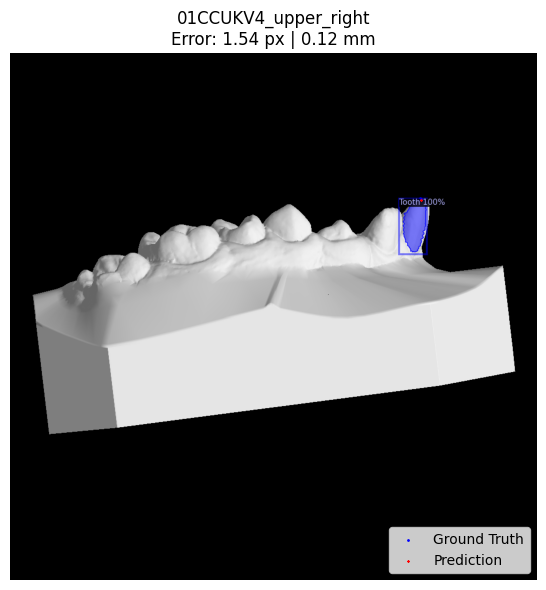

01CCTTK4_lower_right → GT: (763.0, 330.0), Prediction: (771.3934326171875, 330.90576171875)


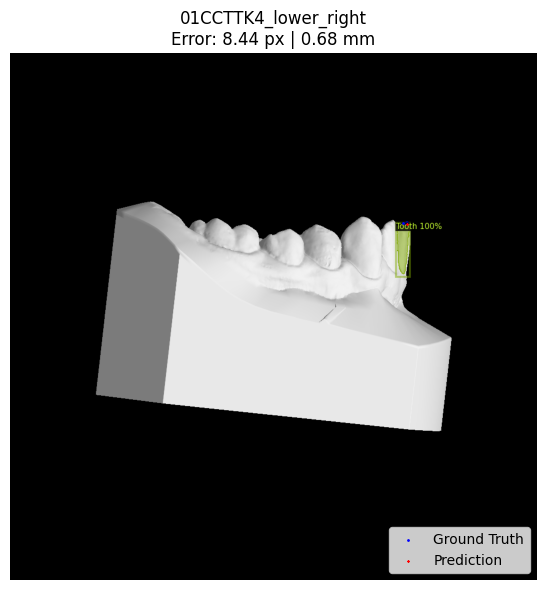

01E1XHG8_upper_right → GT: (826.0, 291.0), Prediction: (833.142333984375, 292.1320495605469)


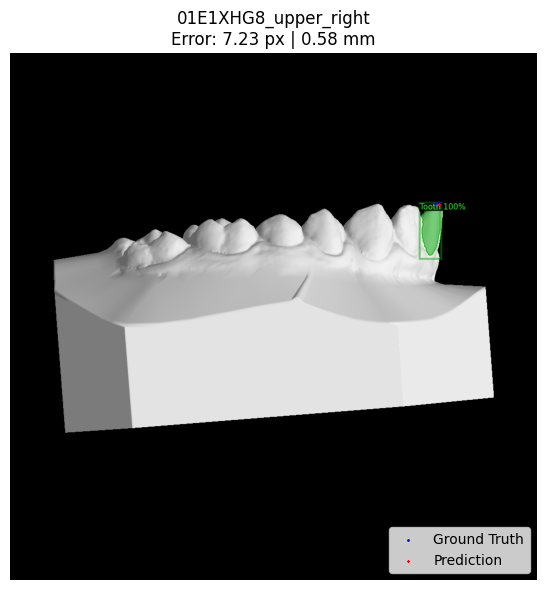

01CDZ2WA_upper_left → GT: (764.0, 267.0), Prediction: (762.2791748046875, 268.8342590332031)


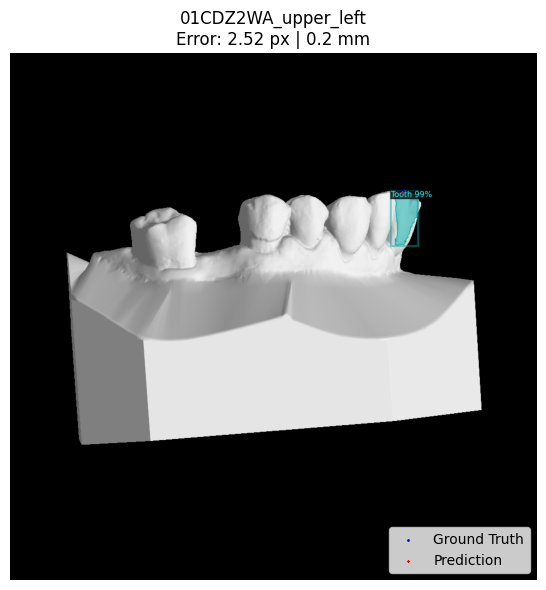

0U1LI1CB_lower_right → GT: (781.0, 402.0), Prediction: (769.3938598632812, 394.96978759765625)


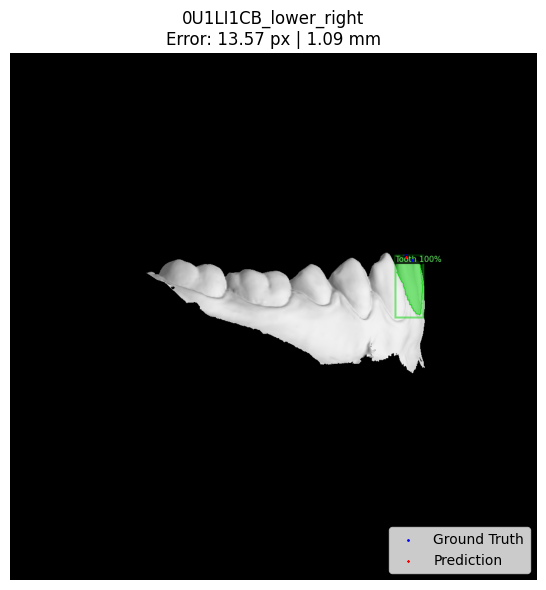

0OTKQ5J9_upper_right → GT: (776.0, 255.0), Prediction: (775.929931640625, 255.04380798339844)


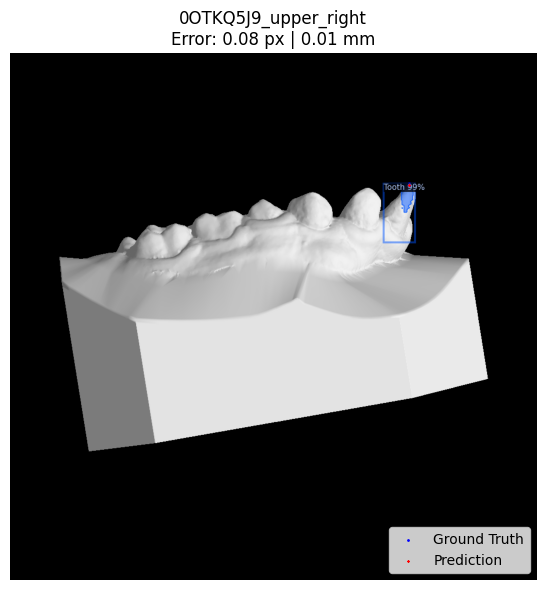

01CCUKV4_lower_left → GT: (869.0, 372.0), Prediction: (870.2949829101562, 373.041748046875)


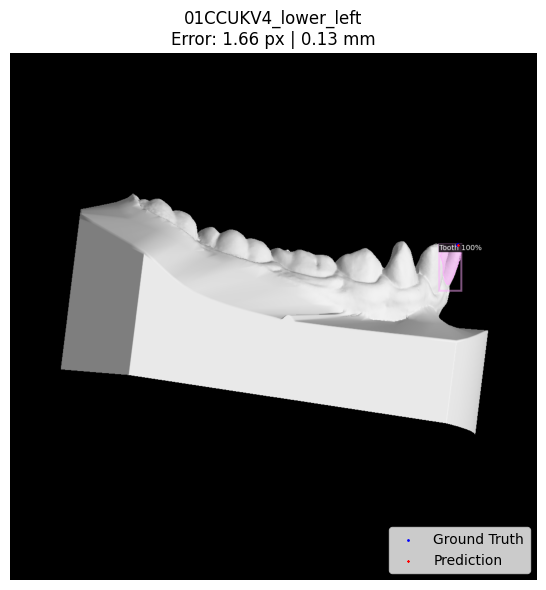

01A91JH6_upper_left → GT: (771.0, 297.0), Prediction: (771.6234741210938, 296.77606201171875)


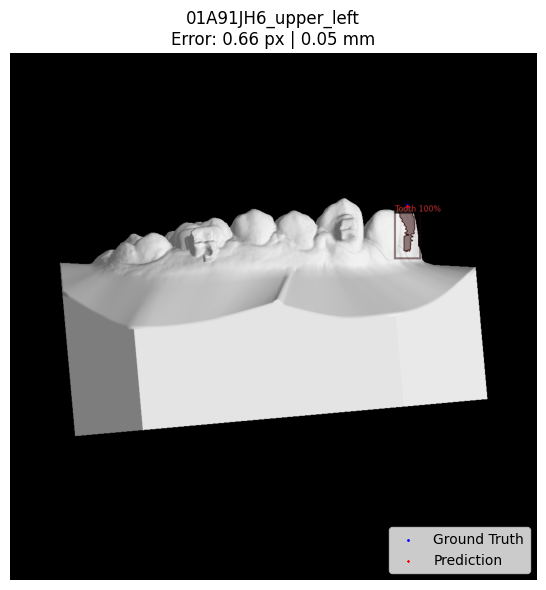

01AS72AN_lower_right → GT: (778.0, 340.0), Prediction: (774.238525390625, 342.2103576660156)


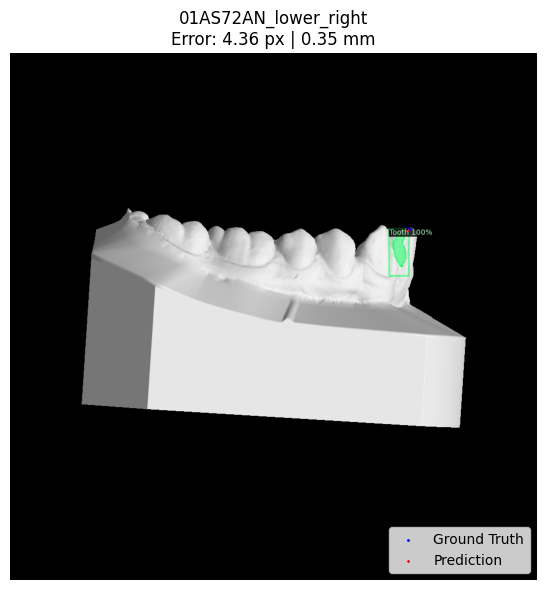

01CDZ2WA_upper_right → GT: (774.0, 263.0), Prediction: (748.913330078125, 265.859619140625)


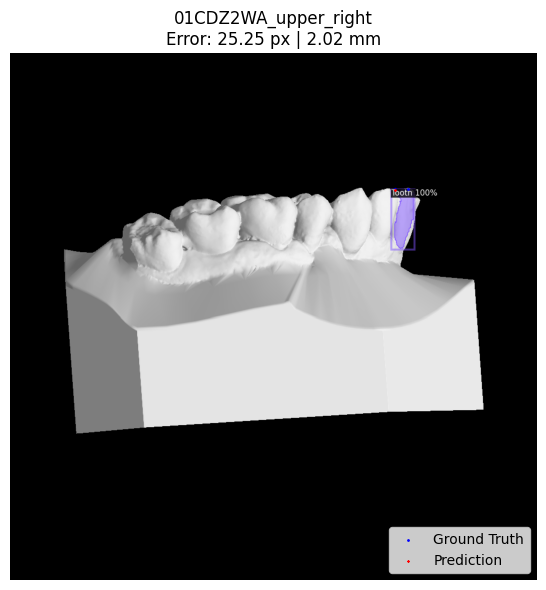

01CJ68G2_upper_right → GT: (829.0, 278.0), Prediction: (831.664794921875, 279.309814453125)


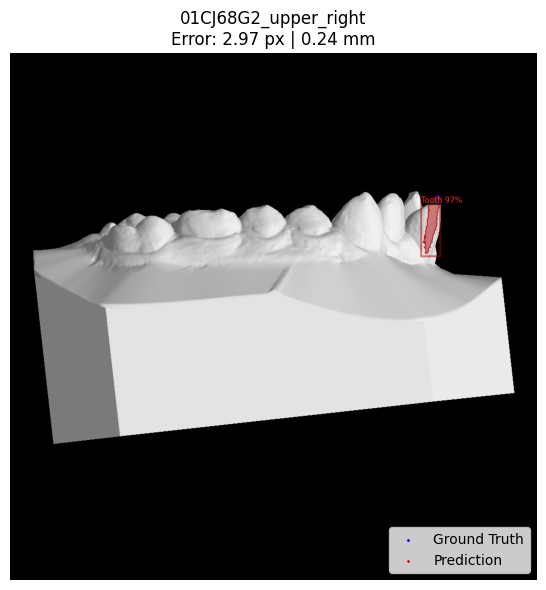

01ADUNMV_upper_right → GT: (825.0, 316.0), Prediction: (826.3543701171875, 317.332763671875)


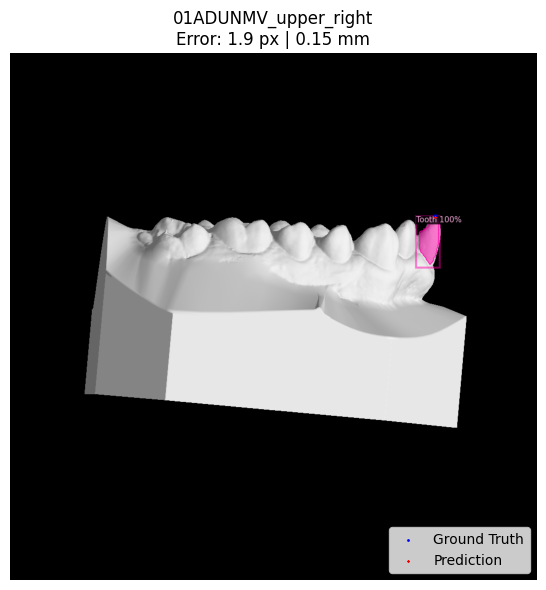

01AFES4K_lower_left → GT: (805.0, 380.0), Prediction: (787.03125, 383.1589660644531)


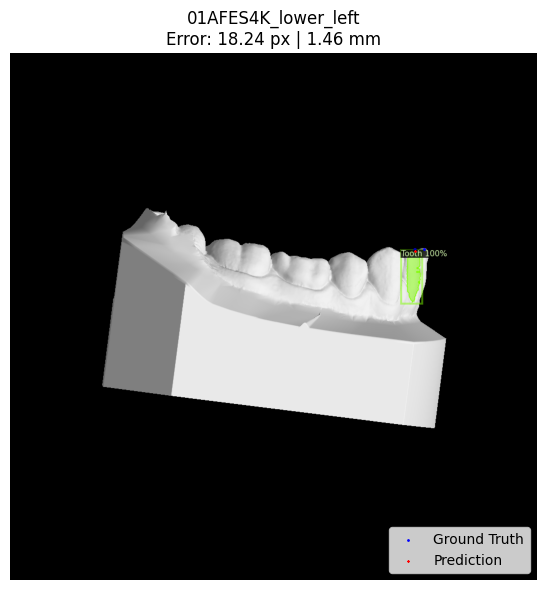

0VYQUKGQ_upper_right → GT: (782.0, 387.0), Prediction: (782.8585205078125, 388.4721374511719)


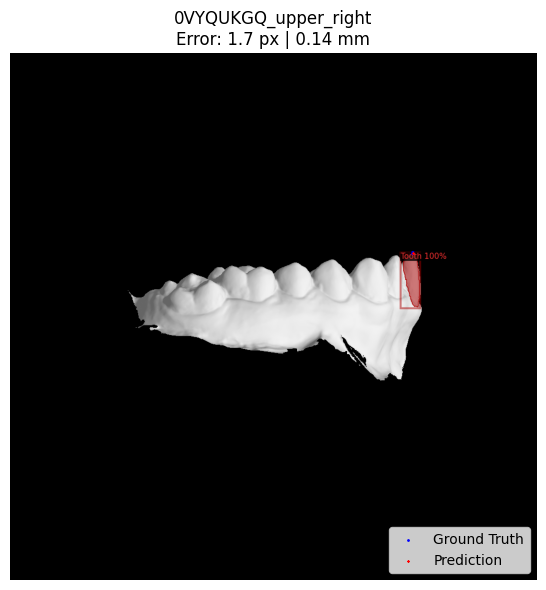

01E1XHG8_lower_right → GT: (838.0, 341.0), Prediction: (805.1326904296875, 337.82318115234375)


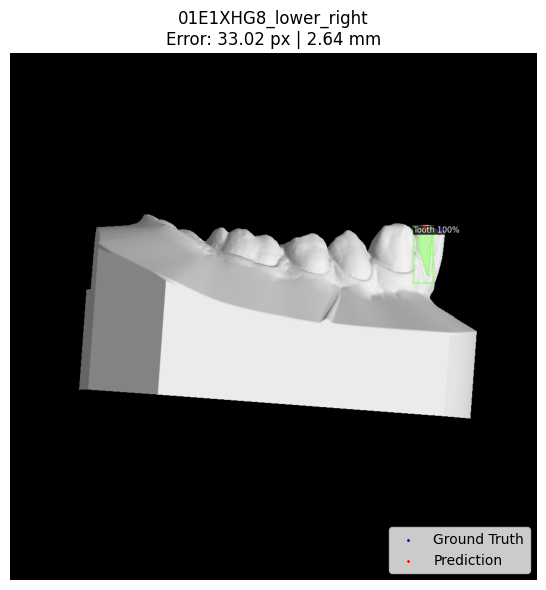

0TMOBYXS_upper_right → GT: (740.0, 264.0), Prediction: (747.6605224609375, 264.05206298828125)


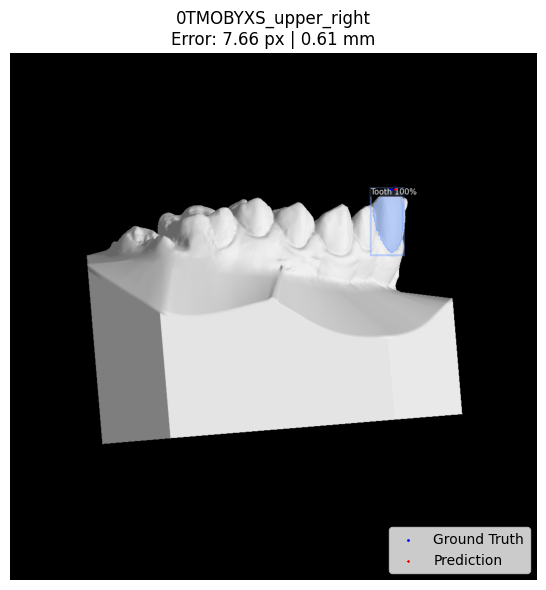

0VFZZY32_upper_right → GT: (790.0, 383.0), Prediction: (792.0913696289062, 383.4079284667969)


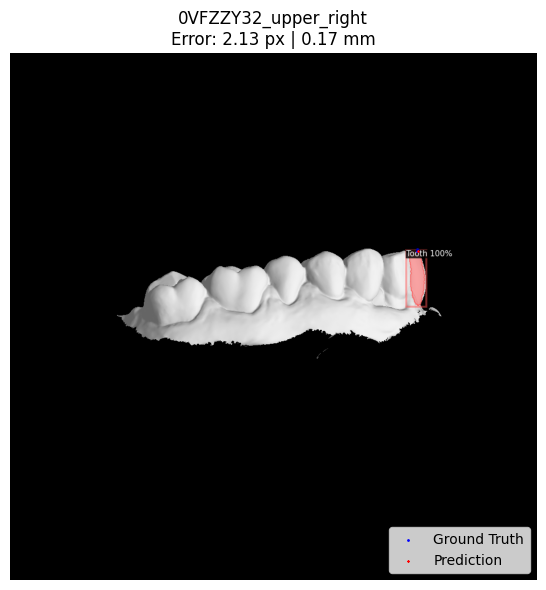

01DXDP2R_upper_left → GT: (722.0, 274.0), Prediction: (721.7196655273438, 275.8872985839844)


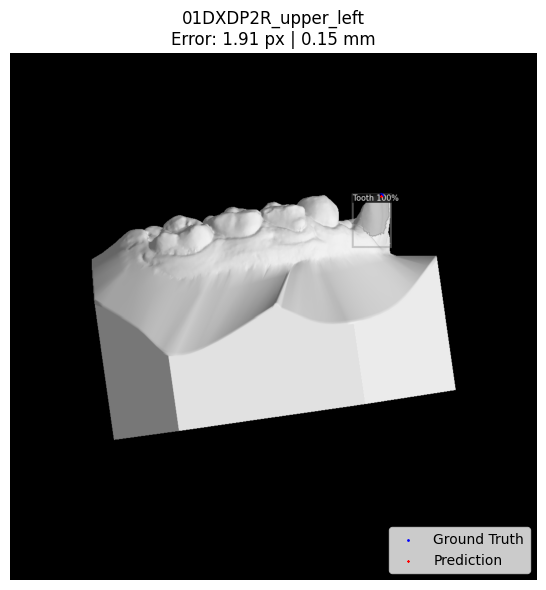

01E5PXS8_lower_left → GT: (784.0, 333.0), Prediction: (784.0350341796875, 334.2230529785156)


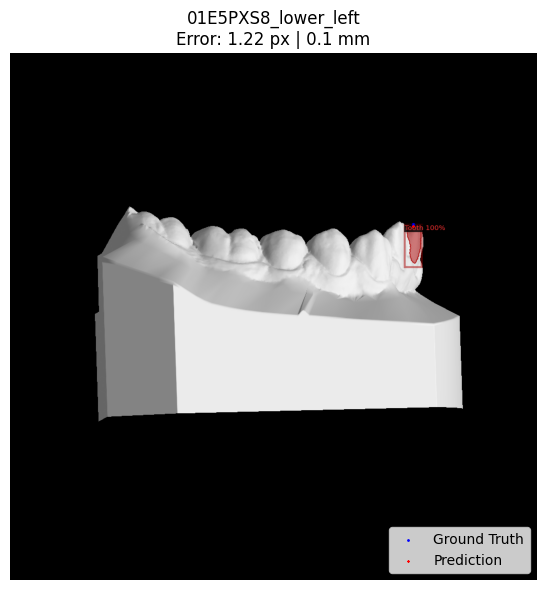

❌ No valid prediction for: 01A6H4PZ_lower_right
01AS9ER0_lower_right → GT: (816.0, 349.0), Prediction: (803.8969116210938, 344.9515686035156)


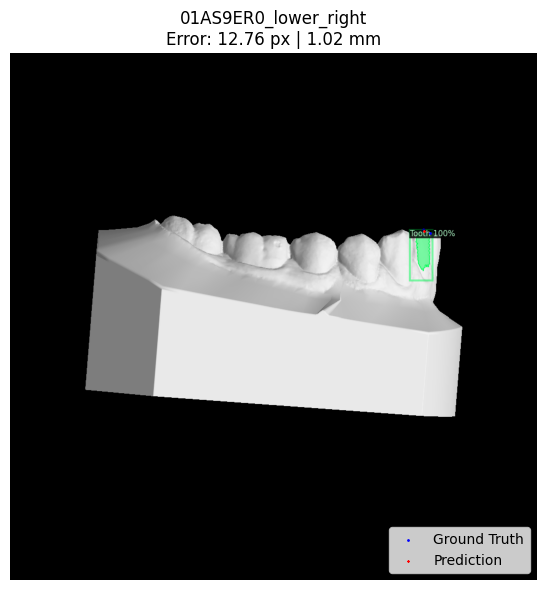

01ADYT70_lower_left → GT: (779.0, 364.0), Prediction: (776.0104370117188, 364.36419677734375)


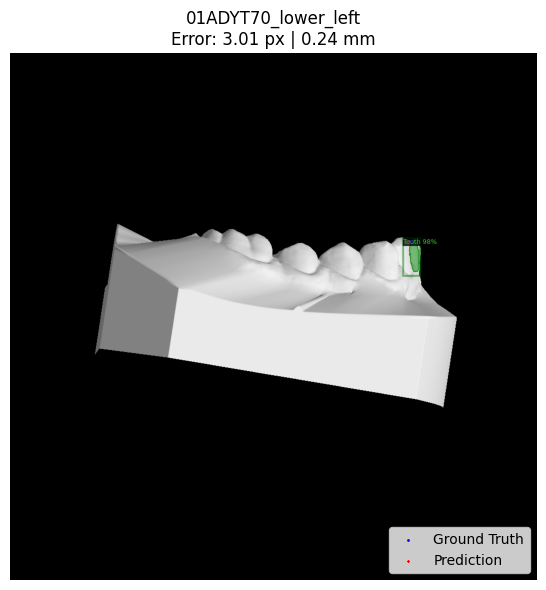

0U1LI1CB_upper_left → GT: (828.0, 373.0), Prediction: (826.9105834960938, 371.3270568847656)


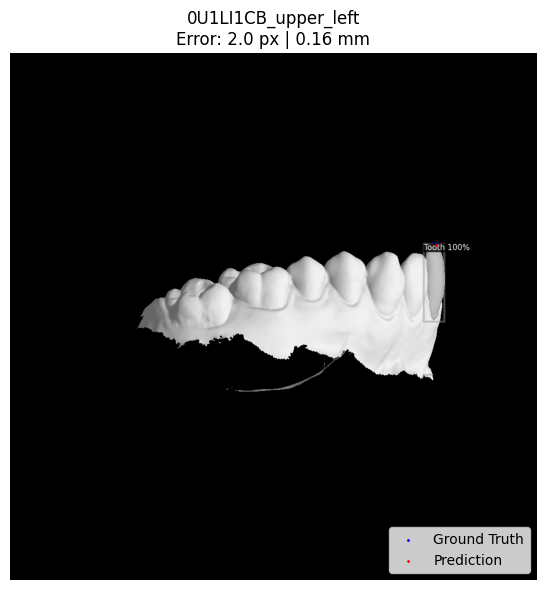

01A9282X_lower_left → GT: (766.0, 346.0), Prediction: (763.3232421875, 348.3609313964844)


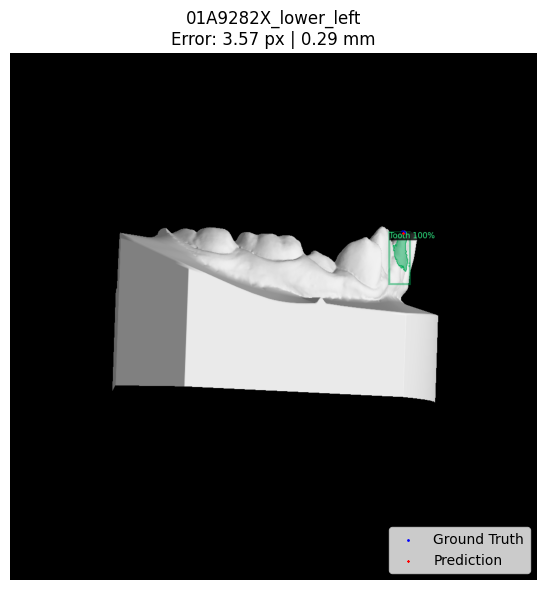

01A6GW4A_lower_left → GT: (870.0, 338.0), Prediction: (863.917724609375, 340.06207275390625)


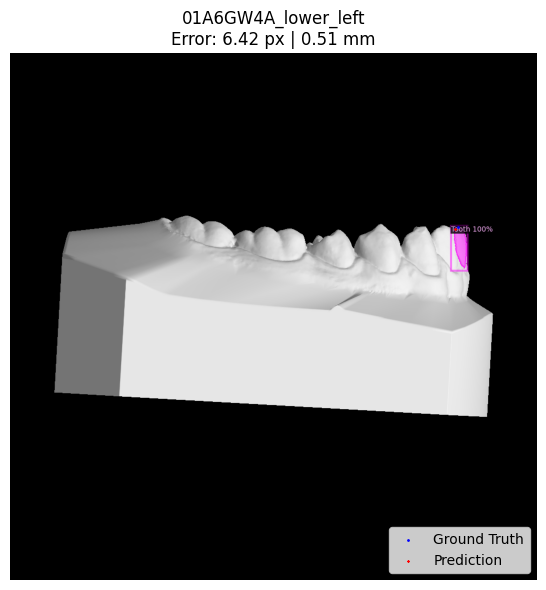

01ADYT70_lower_right → GT: (768.0, 359.0), Prediction: (768.2869262695312, 359.9027404785156)


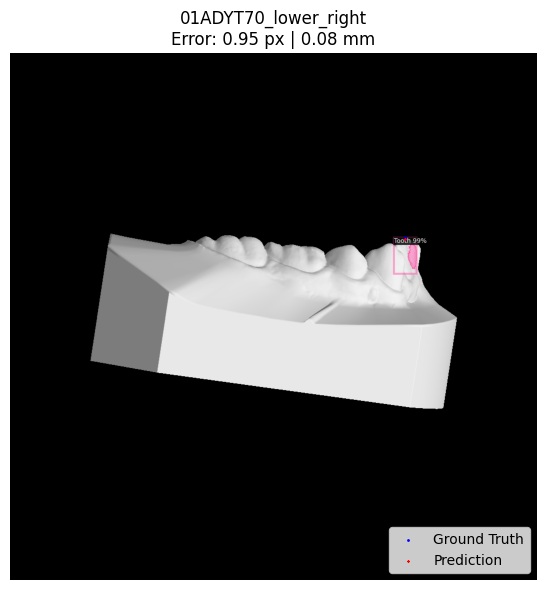

01A6HAN6_lower_left → GT: (788.0, 335.0), Prediction: (771.7874755859375, 330.8733215332031)


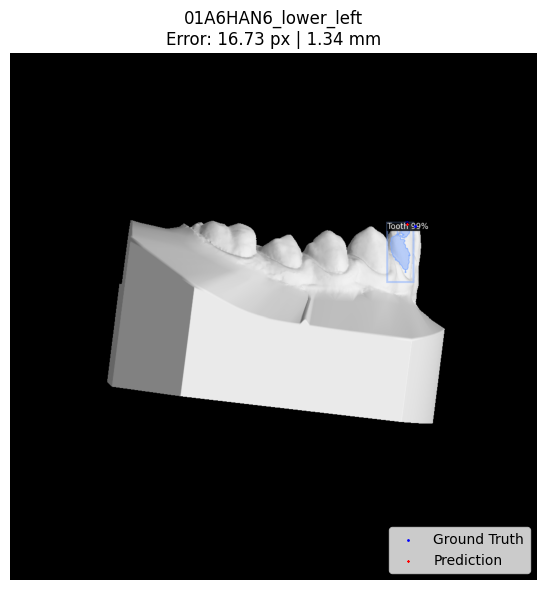

0U1LI1CB_lower_left → GT: (781.0, 399.0), Prediction: (792.6677856445312, 400.52264404296875)


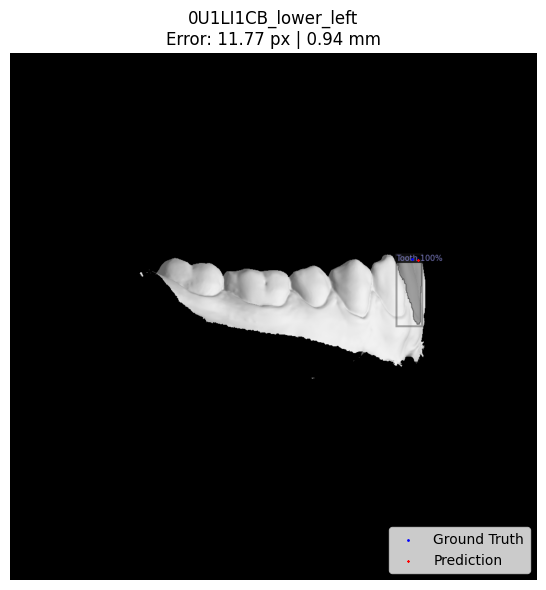

01CJ68G2_upper_left → GT: (782.0, 264.0), Prediction: (785.3404541015625, 267.681396484375)


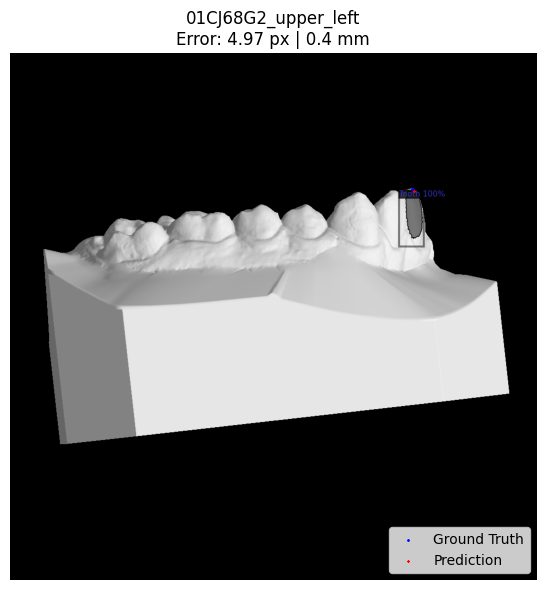

01A6HAN6_lower_right → GT: (790.0, 338.0), Prediction: (778.8088989257812, 339.49481201171875)


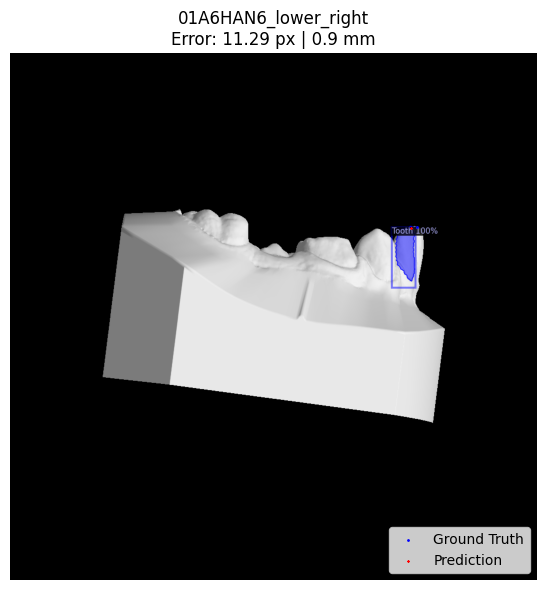

01A6HG3N_upper_right → GT: (796.0, 272.0), Prediction: (802.8656005859375, 272.108154296875)


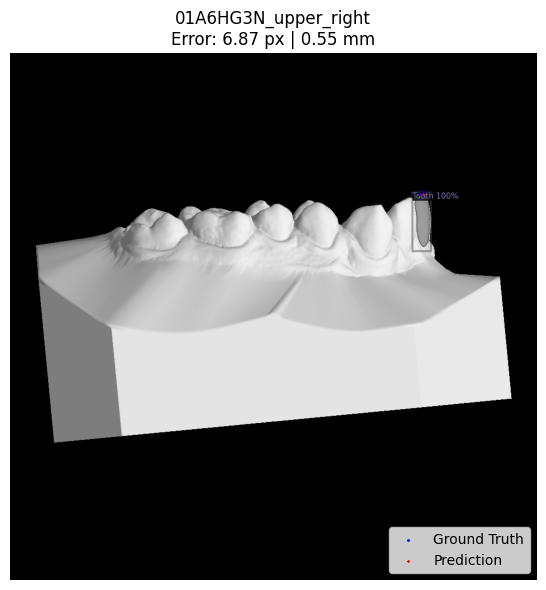

01AS9ER0_lower_left → GT: (813.0, 349.0), Prediction: (795.68896484375, 345.94537353515625)


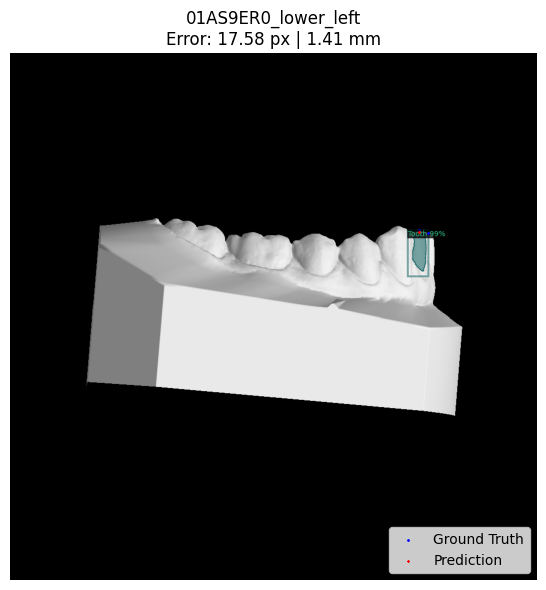

01CCTTK4_upper_right → GT: (744.0, 284.0), Prediction: (745.3406982421875, 284.9969177246094)


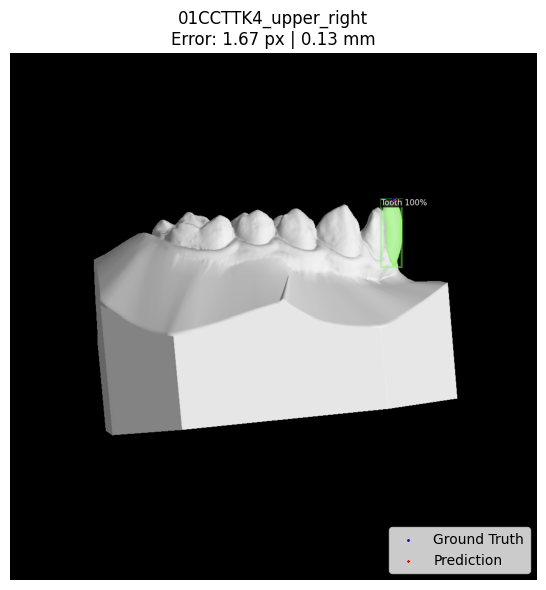

01AVY0SK_upper_left → GT: (809.0, 291.0), Prediction: (808.5379028320312, 291.9954528808594)


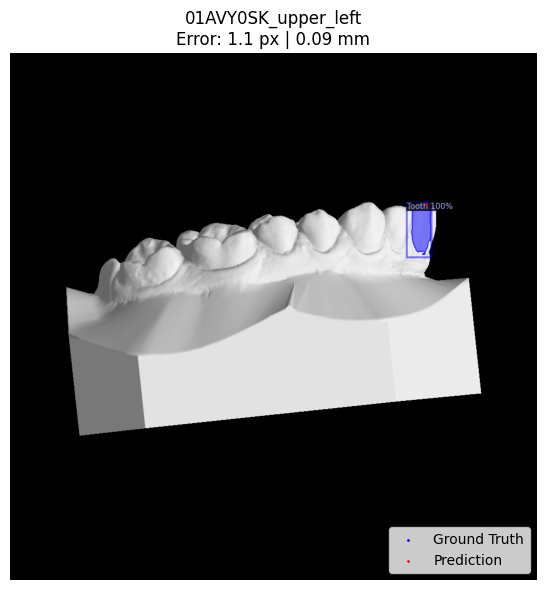

01DXDP2R_upper_right → GT: (722.0, 272.0), Prediction: (722.0527954101562, 270.00592041015625)


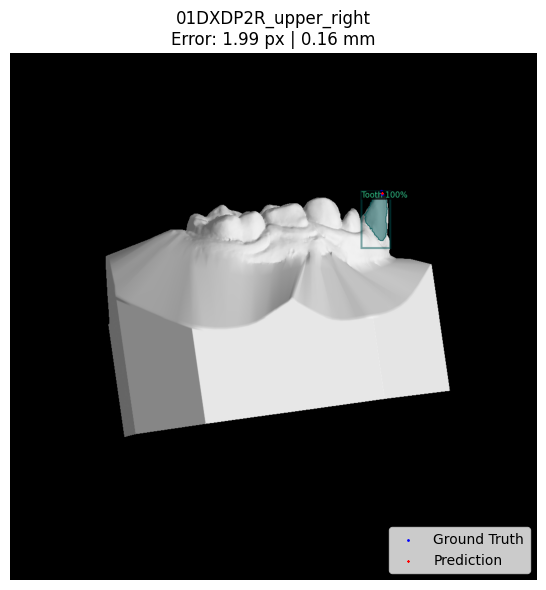

01AS003D_upper_left → GT: (706.0, 302.0), Prediction: (709.170166015625, 302.0903625488281)


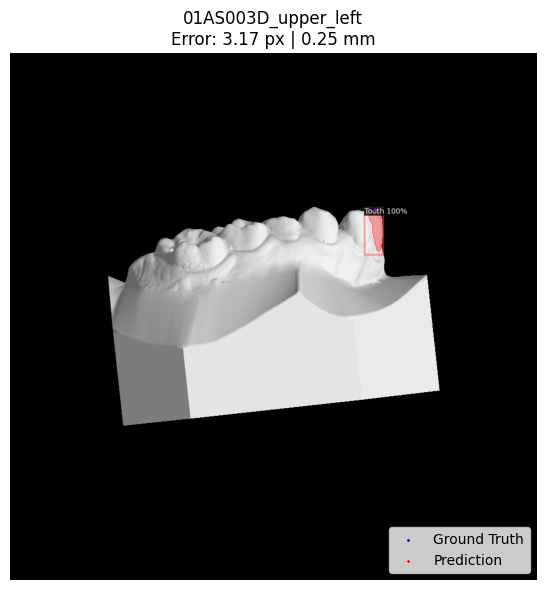

01A6GW4A_lower_right → GT: (865.0, 336.0), Prediction: (871.5706176757812, 340.20501708984375)


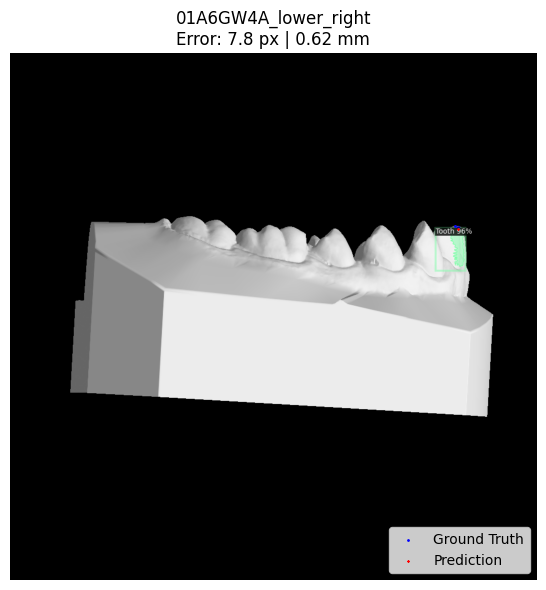

01CCTTK4_lower_left → GT: (769.0, 330.0), Prediction: (745.8246459960938, 323.6453552246094)


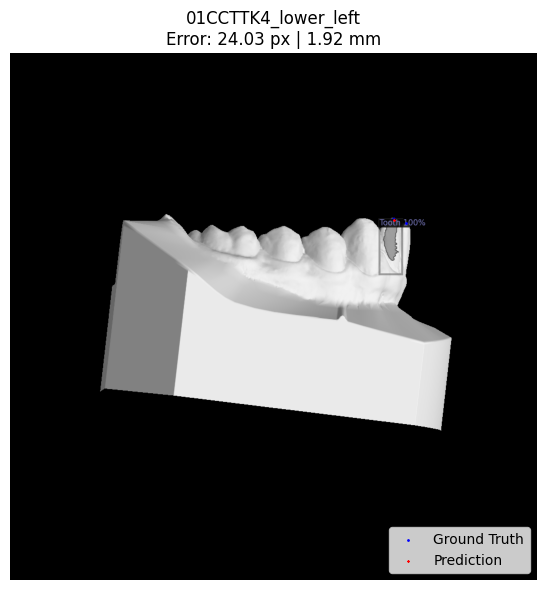

01A9282X_lower_right → GT: (771.0, 345.0), Prediction: (772.7285766601562, 346.72821044921875)


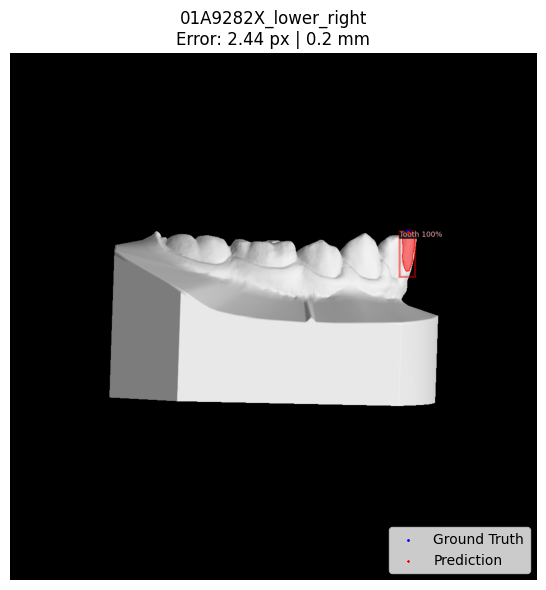

01A6HE9H_upper_left → GT: (774.0, 287.0), Prediction: (773.7974853515625, 287.9851989746094)


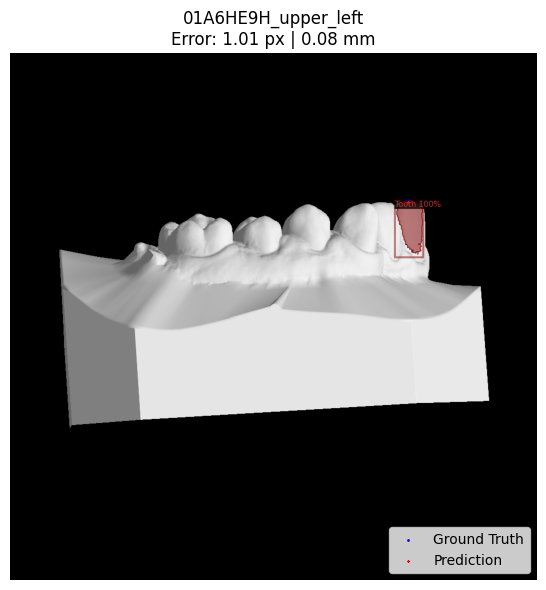

01AS003D_upper_right → GT: (701.0, 300.0), Prediction: (698.1456909179688, 299.4832458496094)


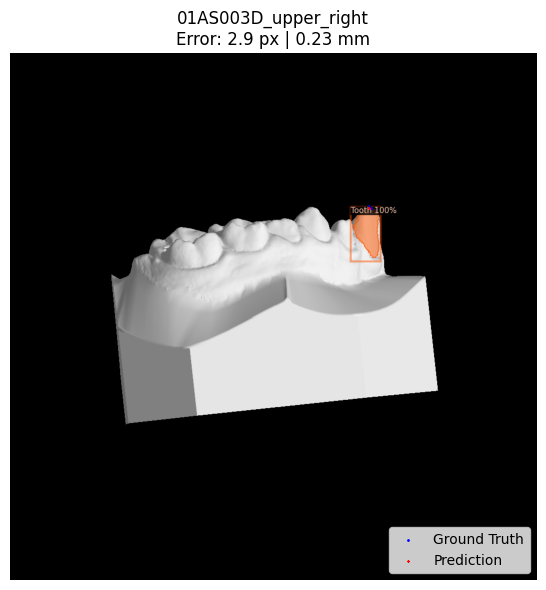

01AS72AN_upper_left → GT: (761.0, 318.0), Prediction: (763.3627319335938, 318.9812927246094)


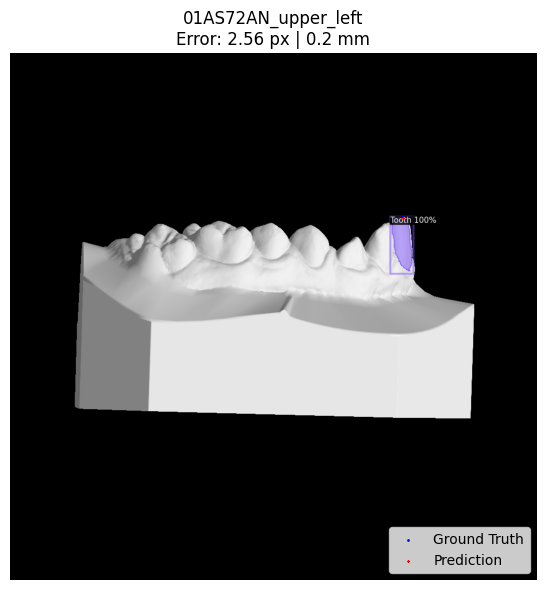

01A6HE9H_lower_right → GT: (811.0, 367.0), Prediction: (807.1142578125, 365.44525146484375)


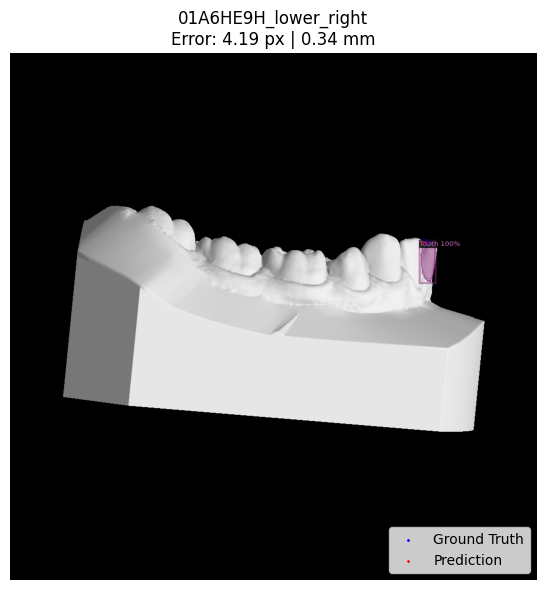

❌ No valid prediction for: 01CCUKV4_lower_right
01AFES4K_upper_left → GT: (780.0, 318.0), Prediction: (781.0850830078125, 316.7738037109375)


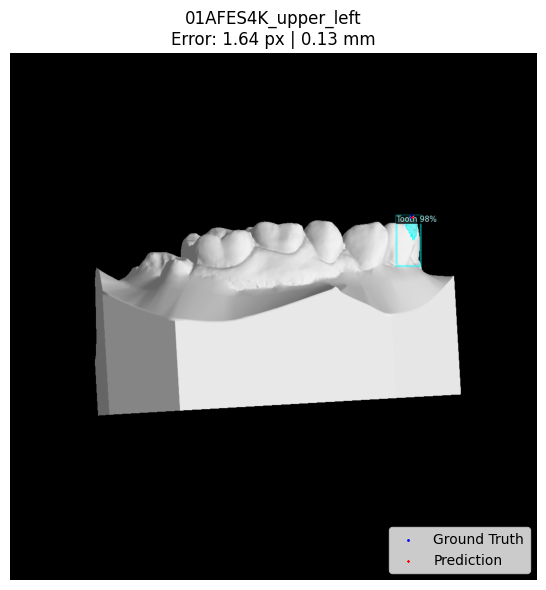

01A6H4PZ_lower_left → GT: (803.0, 281.0), Prediction: (789.9935913085938, 280.57666015625)


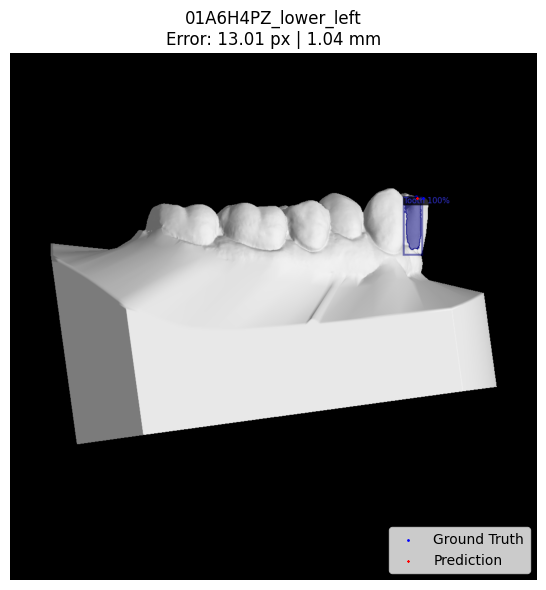

0VFZZY32_upper_left → GT: (791.0, 380.0), Prediction: (791.3211669921875, 379.7537841796875)


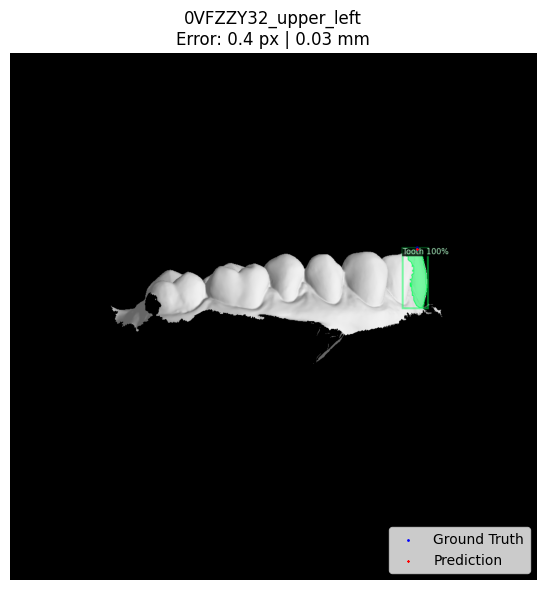

01A6H4PZ_upper_left → GT: (795.0, 294.0), Prediction: (795.0075073242188, 293.2099609375)


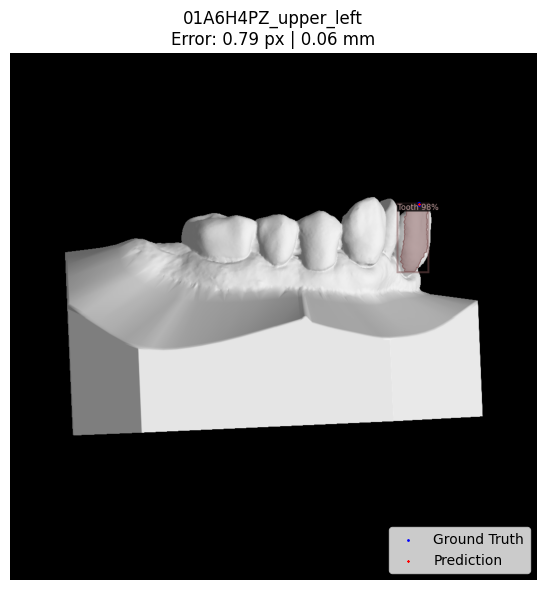

01AKES86_upper_left → GT: (808.0, 302.0), Prediction: (810.1124267578125, 303.9994201660156)


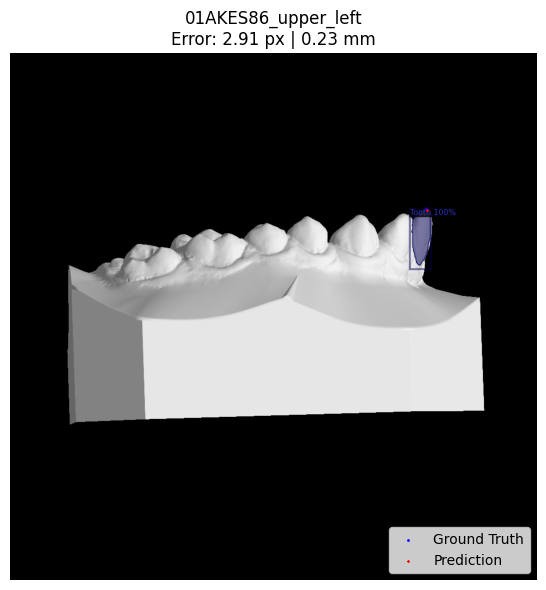

01E1XHG8_upper_left → GT: (828.0, 286.0), Prediction: (826.5586547851562, 288.4830627441406)


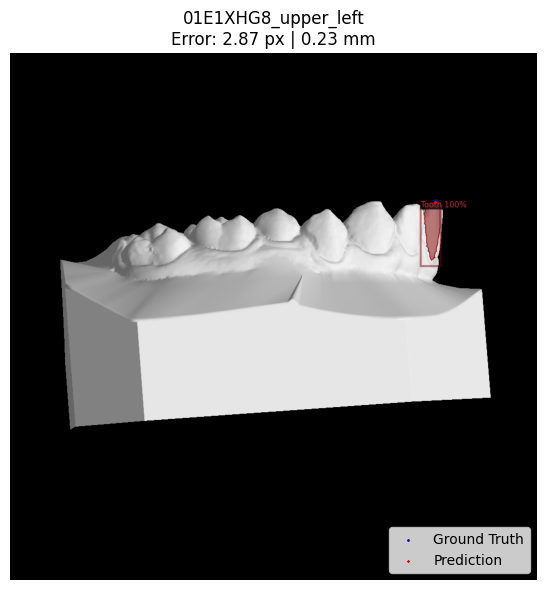

01A91JH6_upper_right → GT: (768.0, 293.0), Prediction: (768.1119995117188, 293.6500244140625)


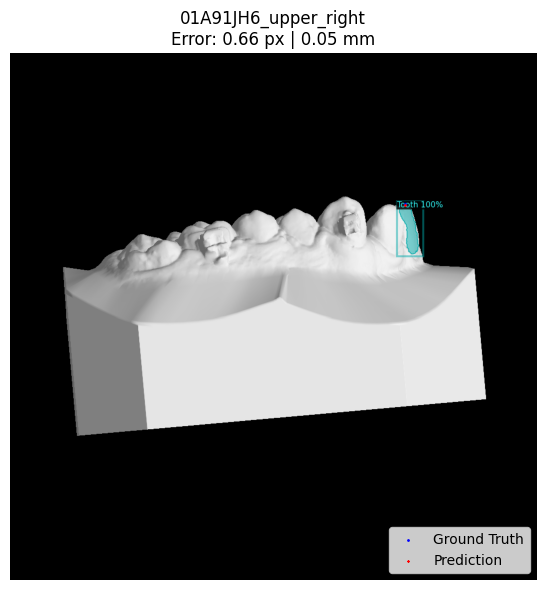

0Y047OQK_upper_left → GT: (865.0, 402.0), Prediction: (865.2952880859375, 403.7381896972656)


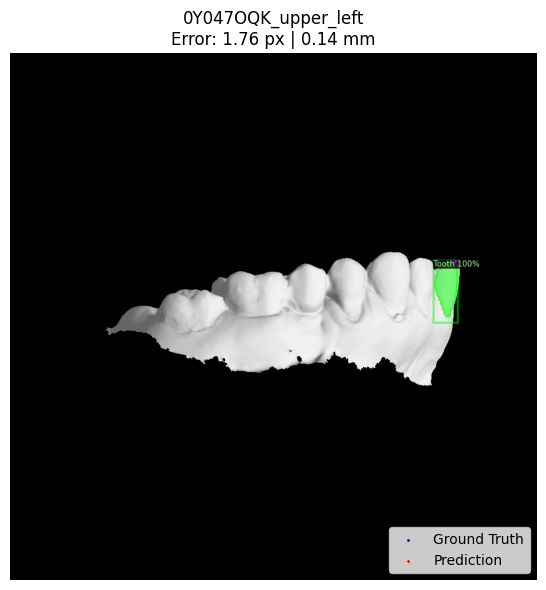

01AVY0SK_upper_right → GT: (793.0, 289.0), Prediction: (794.743896484375, 290.46282958984375)


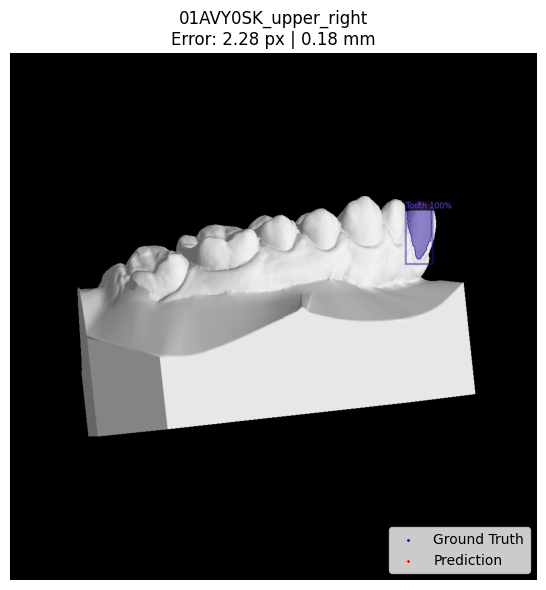

0OTKQ5J9_upper_left → GT: (777.0, 251.0), Prediction: (777.09326171875, 252.37522888183594)


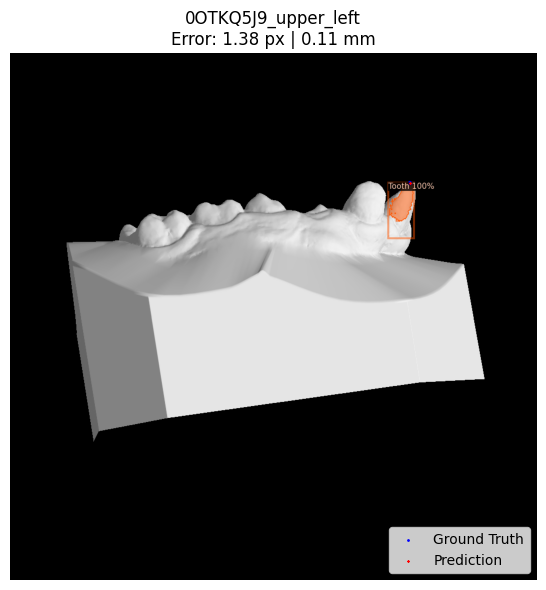

01A6HAN6_upper_right → GT: (724.0, 298.0), Prediction: (724.7922973632812, 297.1029357910156)


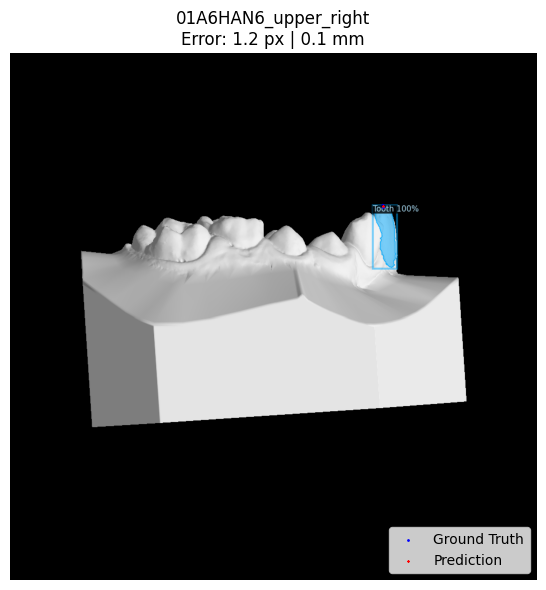

0TMOBYXS_upper_left → GT: (744.0, 264.0), Prediction: (707.68310546875, 336.5171813964844)


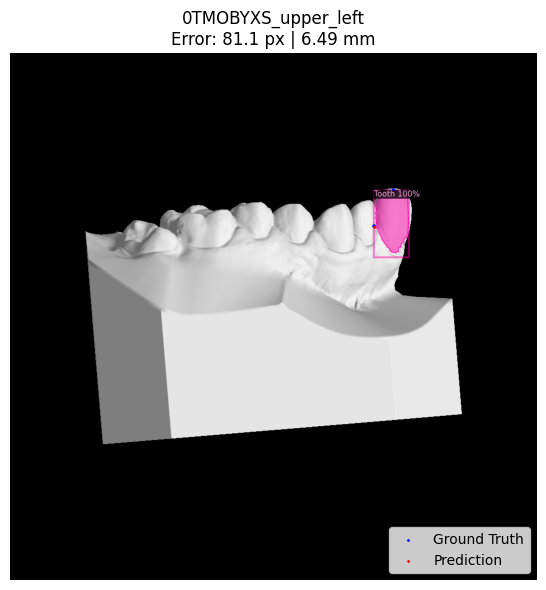

01AS72AN_upper_right → GT: (767.0, 319.0), Prediction: (766.7012329101562, 318.1849060058594)


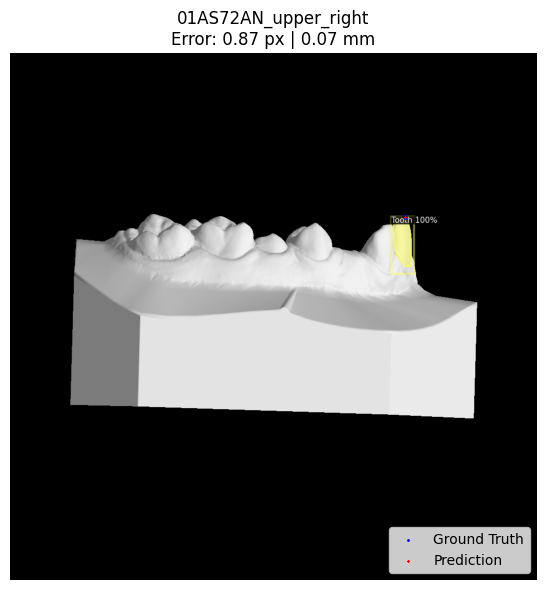

01A6HAN6_upper_left → GT: (724.0, 297.0), Prediction: (723.9619140625, 299.7868957519531)


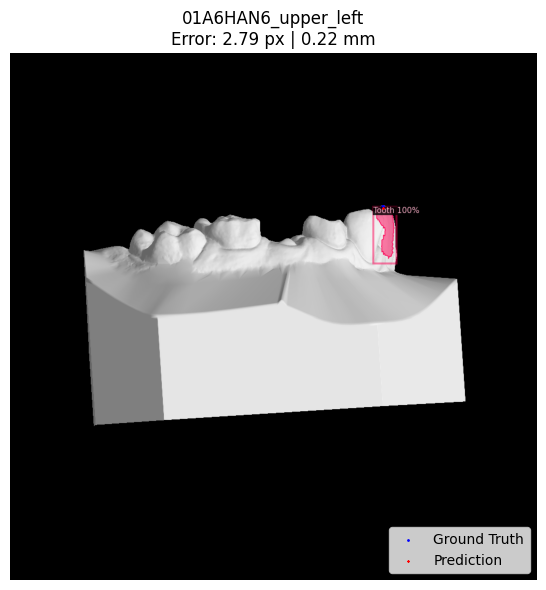

01AFES4K_upper_right → GT: (800.0, 322.0), Prediction: (794.0311279296875, 322.150390625)


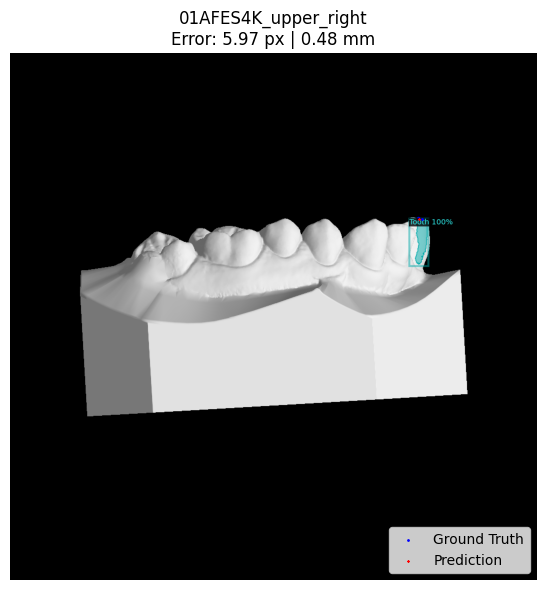

01AS9ER0_upper_right → GT: (761.0, 273.0), Prediction: (760.1731567382812, 272.2470397949219)


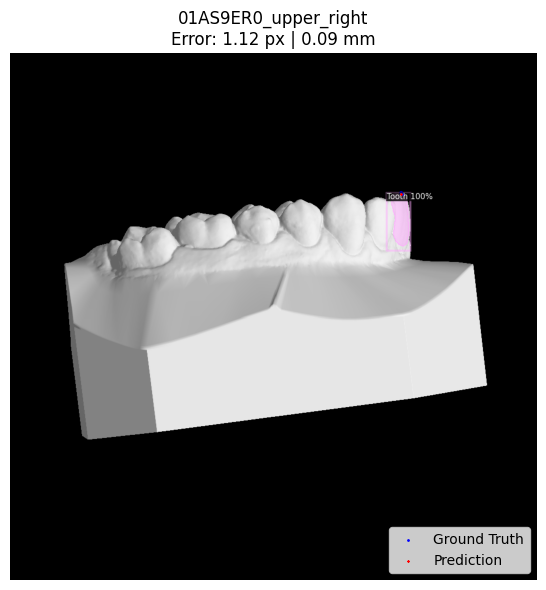

✅ Evaluation complete. Results saved to: inference_evaluation_blind.csv


In [38]:
import os
import cv2
import csv
import math
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog

# === Paths ===
labels_file = "Updated_Labels.csv"
image_folder = "Billeder 2"
output_csv = "inference_evaluation_blind.csv"
PIXEL_TO_MM = 0.08

# === Load Ground Truth ===
ground_truth = {}
with open(labels_file, mode="r", newline="") as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        filename, x, y = [col.strip() for col in row]
        filename = os.path.splitext(filename)[0]
        ground_truth[filename] = (float(x), float(y))

# === Main Loop ===
rows = [["Filename", "X_True", "Y_True", "X_Model", "Y_Model", "Euc_dist", "mm_Dist"]]
image_files = [f for f in os.listdir(image_folder) if f.endswith((".jpg", ".png", ".jpeg"))]

for image_file in image_files:
    filename = os.path.splitext(image_file)[0]
    image_path = os.path.join(image_folder, image_file)

    if filename not in ground_truth:
        print(f"⚠️ No ground truth for: {filename}")
        continue

    image = cv2.imread(image_path)
    outputs = predictor(image)
    instances = outputs["instances"].to("cpu")

    if len(instances) == 0 or not instances.has("pred_keypoints"):
        print(f"❌ No valid prediction for: {filename}")
        continue

    # === Top prediction only ===
    top_idx = instances.scores.argmax()
    instance = instances[top_idx:top_idx+1]  # ✅ Returns an Instances object with 1 element

    pred_x, pred_y, _ = instance.pred_keypoints[0][0].tolist()
    true_x, true_y = ground_truth[filename]

    # === Distance ===
    euc_dist = round(math.sqrt((true_x - pred_x)**2 + (true_y - pred_y)**2), 2)
    mm_dist = round(euc_dist * PIXEL_TO_MM, 2)
    rows.append([filename, true_x, true_y, pred_x, pred_y, euc_dist, mm_dist])

    # === Visualization ===
    v = Visualizer(image[:, :, ::-1], metadata=metadata, scale=1.0, instance_mode=ColorMode.IMAGE)
    out = v.draw_instance_predictions(instance)
    vis_img = out.get_image()

    # Convert to RGB
    vis_img = cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB)

    print(f"{filename} → GT: ({true_x}, {true_y}), Prediction: ({pred_x}, {pred_y})")

    # Plot both keypoints
    plt.figure(figsize=(6, 6))
    plt.imshow(vis_img)
    plt.scatter(true_x, true_y, color="blue", marker="o", s=1, label="Ground Truth")
    plt.scatter(pred_x, pred_y, color="red", marker="x", s=1, label="Prediction")
    plt.title(f"{filename}\nError: {euc_dist} px | {mm_dist} mm")
    plt.axis("off")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

# === Save CSV ===
with open(output_csv, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(rows)

print(f"✅ Evaluation complete. Results saved to: {output_csv}")


In [37]:
import pandas as pd

csv_path = "Updated_Labels.csv"
df = pd.read_csv(csv_path)

# Count occurrences of each filename (without extension)
df["BaseFilename"] = df["Filename"].apply(lambda x: os.path.splitext(x)[0])
duplicates = df["BaseFilename"].value_counts()
duplicates = duplicates[duplicates > 1]

print(f"🔍 Found {len(duplicates)} files with multiple annotations:\n")
print(duplicates)



🔍 Found 0 files with multiple annotations:

Series([], Name: count, dtype: int64)
